# Conditional likelihoods of trajectories

In [2]:
import sys
import os
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from scipy import stats, interpolate
from numba import guvectorize,float64

import glob
import importlib

from analyzer import analyzer, configuration

In [3]:
matplotlib.rc_file_defaults()

In [4]:
def load_path(outpath):
    outpath = pathlib.Path(outpath)
    return np.load(outpath / 'mutual_information.npz')

In [5]:
def concatenate_paths(paths):
    tlens = []
    minfs = []
    for path in paths:
        res = load_path(path)
        tlens.append(res['trajectory_length'])
        minfs.append(res['mutual_information'])
    return {
        "trajectory_length": tlens[0],
        "mutual_information": np.concatenate(minfs)
    }

In [49]:
paths = (os.path.expandvars(f'$GROUP_FOLDER/home-folder/reinhardt/simruns/2019-11-18/run_S15k_{i}') for i in range(1,13))
num_signals = 15_000
mutual_information = concatenate_paths(paths)
num_r, _ = mutual_information["mutual_information"].shape
mutual_information["mutual_information"].shape

(9000, 5000)

In [50]:
x = mutual_information['trajectory_length']
mi = np.zeros((num_r, len(x)))
for i, old in enumerate(mutual_information["mutual_information"]):
    mi[i] = old
mi_mean = np.mean(mi, axis=0)
x,mi_mean

(array([9.9999998e-03, 1.0023057e-02, 1.0046167e-02, ..., 9.9540448e+02,
        9.9769958e+02, 1.0000000e+03], dtype=float32),
 array([0.09724664, 0.09724731, 0.0972492 , ..., 1.92915885, 1.9350625 ,
        1.93924132]))

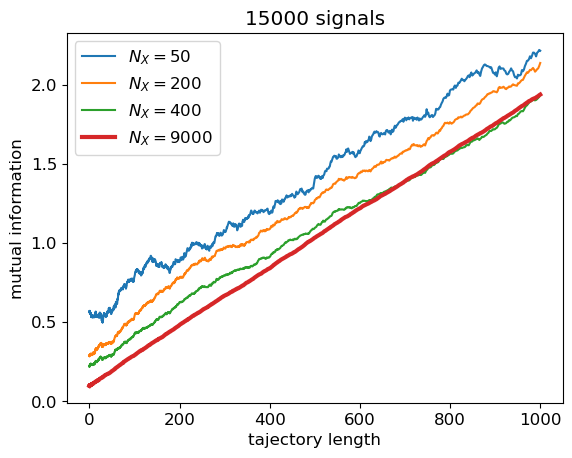

In [51]:
for r in [50, 200, 400]:
    subset_mean = np.mean(mi[:r], axis=0)
    plt.plot(x, subset_mean, label='$N_X={}$'.format(r))
plt.plot(x, mi_mean, label='$N_X={}$'.format(num_r), linewidth=3)
plt.legend()
plt.title('{} signals'.format(num_signals))
plt.ylabel('mutual information')
plt.xlabel('tajectory length');

In [52]:
numerical_x = np.array([6.10351562e-01, 1.22070312e+00, 2.44140625e+00, 4.88281250e+00,
       9.76562500e+00, 1.95312500e+01, 3.90625000e+01, 7.81250000e+01,
       1.56250000e+02, 3.12500000e+02, 6.25000000e+02, 1.25000000e+03,
       2.50000000e+03])
numerical = np.array([0.07155042, 0.07221034, 0.07352942, 0.07616464, 0.08142376,
       0.09190024, 0.1127109 , 0.15391634, 0.23541893, 0.39725253,
       0.72029812, 1.36630923, 2.65833046])

In [53]:
def mut_inf(lamda, rho):
    return lamda/2 * (np.sqrt(1 + rho/lamda) - 1)
from scipy.optimize import curve_fit
def linear(t, inf_rate, offset):
    return t * inf_rate + offset

def rate_from_curve(x, y):
    (rate, offset), _ = curve_fit(linear, x, y, sigma=np.exp(-x/np.max(x)))
    return rate, offset


theoretical_rate = mut_inf(0.005, 0.005)
rate, offset = rate_from_curve(x, mi_mean)
rate_numerical, _ = rate_from_curve(numerical_x, numerical)
print("analytical:  {}\nnumerical:   {}\nmonte carlo: {}".format(theoretical_rate, rate_numerical, rate))

analytical:  0.0010355339059327378
numerical:   0.0010345131030511097
monte carlo: 0.0018477722267823359


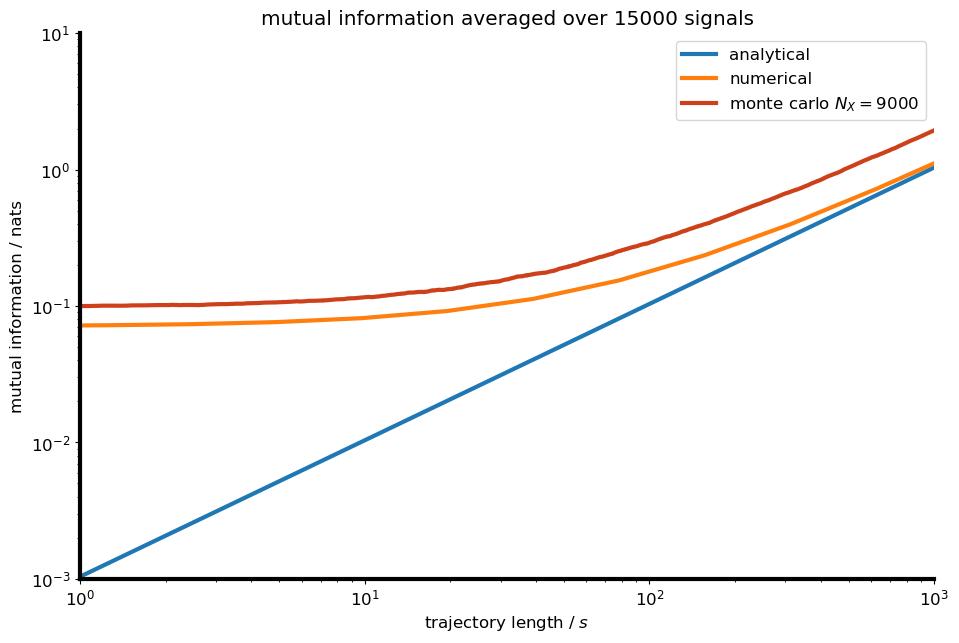

In [54]:
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'TeX Gyre Heros'})
plt.plot(x, theoretical_rate*x, label='analytical', linewidth=3)
plt.plot(numerical_x, numerical, linewidth=3, label='numerical')

plt.plot(x, mi_mean, label='monte carlo $N_X = {}$'.format(num_r), linewidth=3, color='#CD401A')

plt.xlim(1,1250)

ax = plt.gca()
for pos in ['right', 'top']:
    ax.spines[pos].set_visible(False)
    
for pos in ['left', 'bottom']:
    ax.spines[pos].set_linewidth(3)

plt.title('mutual information averaged over {} signals'.format(num_signals))
plt.ylabel('mutual information / nats')
plt.xlabel('trajectory length $/\\; s$')
plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3,1e1)
plt.xlim(1e0,1e3)

plt.gcf().set_size_inches(28/2.54, 18/2.54)
plt.savefig('poster_plot_3.pdf')

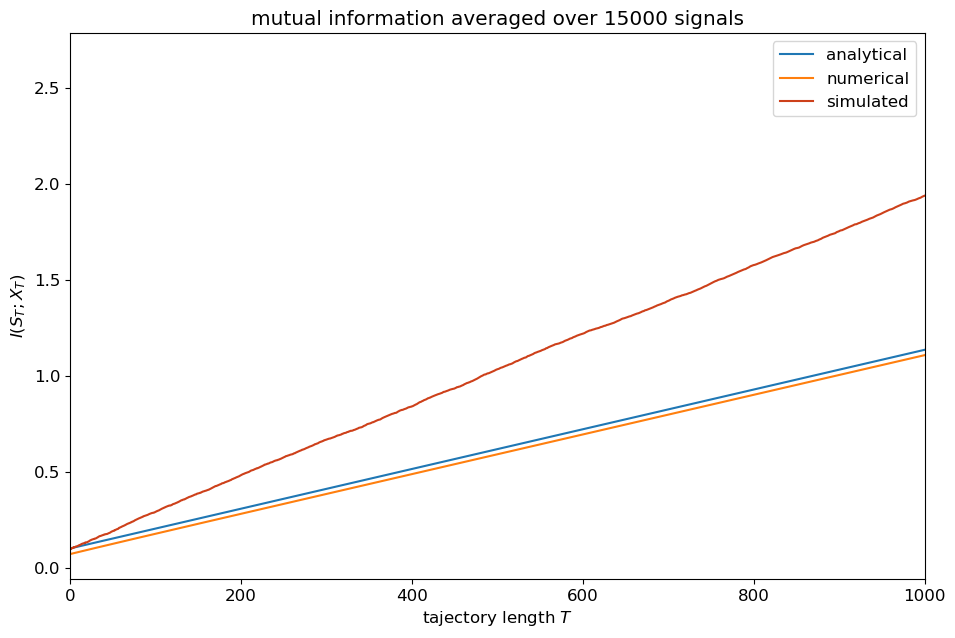

In [55]:
plt.plot(x, theoretical_rate*x + offset, label='analytical')
plt.plot(numerical_x, numerical, label='numerical')
plt.plot(x, mi_mean, label='simulated'.format(num_r), color='#CD401A')
plt.ylabel('$I(S_T;X_T)$')
plt.xlabel('tajectory length $T$')
plt.xlim(0,1000)
plt.gcf().set_size_inches(28/2.54, 18/2.54)
plt.savefig('linear_plot.pdf')
plt.title('mutual information averaged over {} signals'.format(num_signals))
plt.legend();

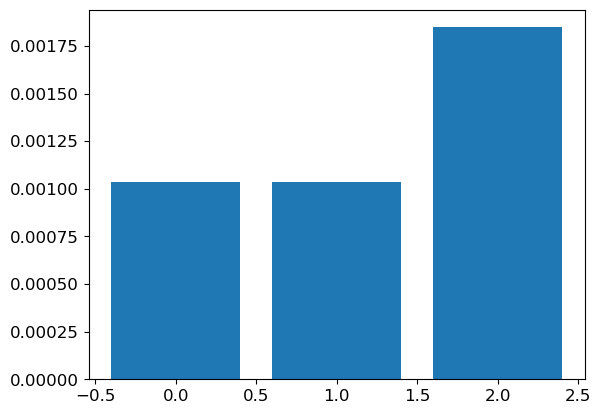

In [56]:
plt.bar(x=np.arange(3), height=[theoretical_rate, rate_from_curve(numerical_x, numerical)[0], rate_from_curve(x, mi_mean)[0]]);

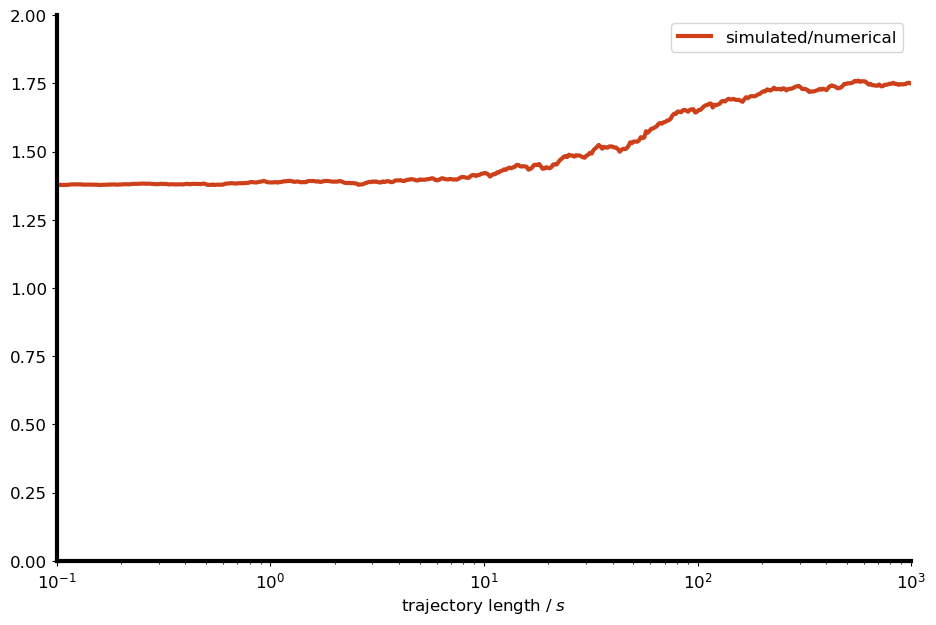

In [57]:
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'TeX Gyre Heros'})
num_int = interpolate.interp1d(numerical_x, numerical, fill_value='extrapolate')
mc_int = interpolate.interp1d(x, mi_mean, fill_value='extrapolate')

xx = np.geomspace(0.1, 1250, 500)

plt.plot(xx, mc_int(xx) / num_int(xx), linewidth=3, color='#CD401A', label="simulated/numerical")

plt.xlim(0.1,1000)

ax = plt.gca()
for pos in ['right', 'top']:
    ax.spines[pos].set_visible(False)
    
for pos in ['left', 'bottom']:
    ax.spines[pos].set_linewidth(3)

plt.xlabel('trajectory length $/\\; s$')

plt.xscale('log')
plt.ylim(0,2)

plt.legend()
plt.gcf().set_size_inches(28/2.54, 18/2.54)

Text(0, 0.5, 'Response')

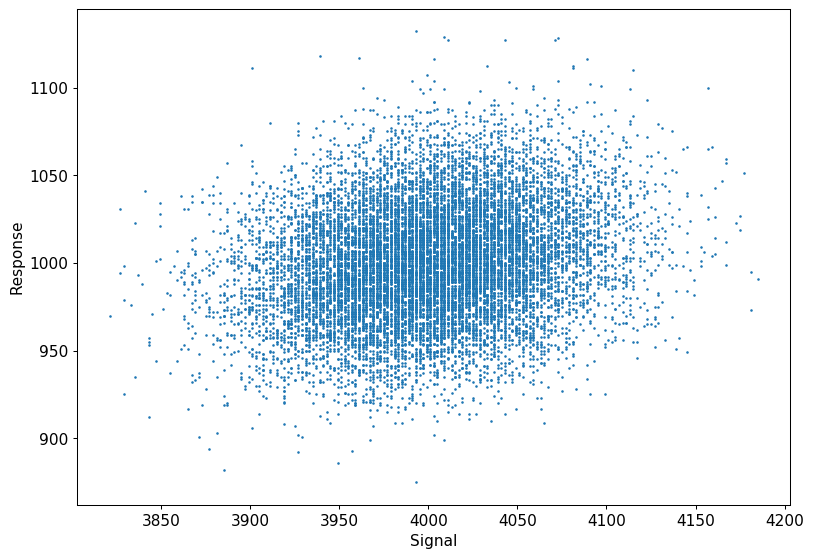

In [87]:
data = np.load(pathlib.Path.home() / 'testrun' / 'equilibrated.npy')
plt.scatter(x=data[:,0], y=data[:,1], s=1)
plt.xlabel('Signal')
plt.ylabel('Response')

(-20, 0)

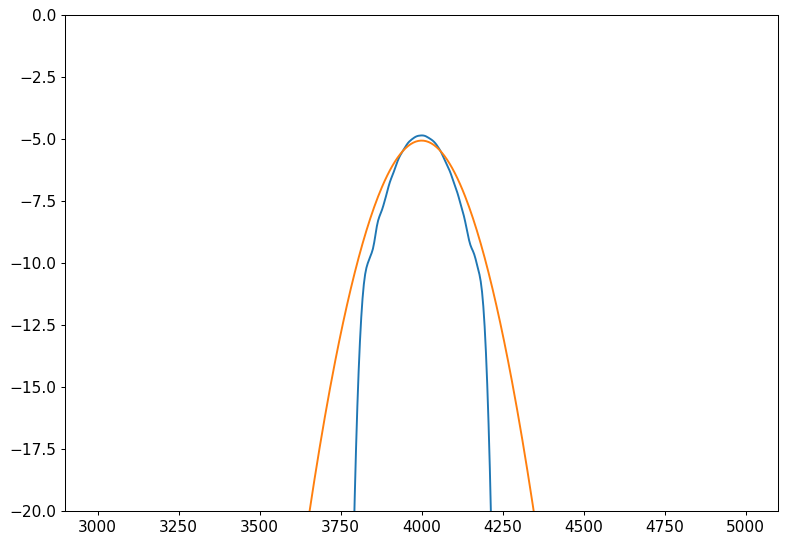

In [78]:
kde_s = stats.gaussian_kde(data[:,0])
x = np.linspace(3000, 5000, 500)
thdstr = stats.norm(loc=20/0.005, scale=np.sqrt(20/0.005))
plt.plot(x, kde_s.logpdf(x))
plt.plot(x, thdstr.logpdf(x))
plt.ylim(-20,0)

In [89]:
x, y = np.meshgrid(np.linspace(3700, 4300, 100), np.linspace(800, 1200, 100))

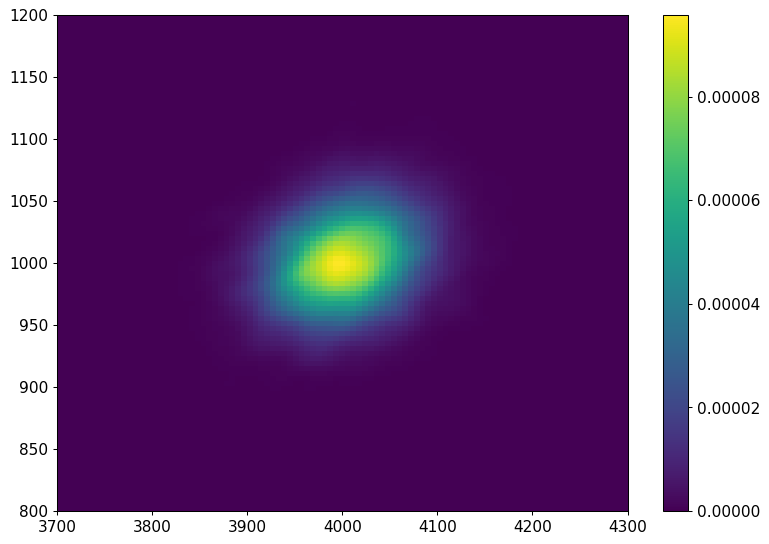

In [91]:
kde = stats.gaussian_kde(data.T)
z = kde.pdf([x.flatten(),y.flatten()]).reshape(x.shape)
plt.pcolormesh(x, y, z)
plt.colorbar();

In [21]:
kde.dataset[:,5,None] - np.array([[100,200,300],[100,200,300]])

array([[3877, 3777, 3677],
       [ 965,  865,  765]])

In [35]:
kde._norm_factor

478.99031097649106